In [6]:
import cv2
import mediapipe as mp
import time

In [7]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

Nose coordinates: (748.0377405881882, 260.63263416290283)


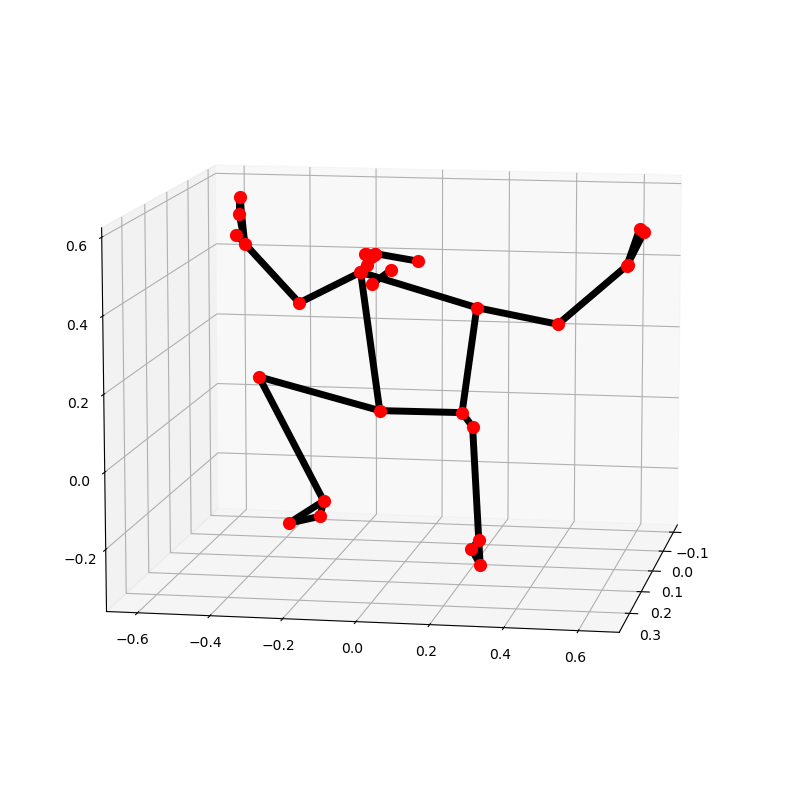

In [17]:
# For static images:
IMAGE_FILES = ["squat.jpg"]
BG_COLOR = (192, 192, 192) # gray
with mp_pose.Pose(
    static_image_mode=True,
    model_complexity=2,
    enable_segmentation=True,
    min_detection_confidence=0.5) as pose:
  for idx, file in enumerate(IMAGE_FILES):
    image = cv2.imread(file)
    image_height, image_width, _ = image.shape
    # Convert the BGR image to RGB before processing.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if not results.pose_landmarks:
      continue
    print(
        f'Nose coordinates: ('
        f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width}, '
        f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_height})'
    )

annotated_image = image.copy()
# Draw segmentation on the image.
# To improve segmentation around boundaries, consider applying a joint
# bilateral filter to "results.segmentation_mask" with "image".
condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
bg_image = np.zeros(image.shape, dtype=np.uint8)
bg_image[:] = BG_COLOR
annotated_image = np.where(condition, annotated_image, bg_image)
# Draw pose landmarks on the image.
mp_drawing.draw_landmarks(
    annotated_image,
    results.pose_landmarks,
    mp_pose.POSE_CONNECTIONS,
    landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
cv2.imwrite('/tmp/annotated_image' + str(idx) + '.png', annotated_image)
# Plot pose world landmarks.
mp_drawing.plot_landmarks(
    results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

In [18]:
# For webcam input:
cap = cv2.VideoCapture(0)
with mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as pose:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image)

    # Draw the pose annotation on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    # Flip the image horizontally for a selfie-view display.
    cv2.imshow('MediaPipe Pose', cv2.flip(image, 1))
    if cv2.waitKey(5) & 0xFF == 27:
      break
cap.release()

[ WARN:0@967.968] global /home/conda/feedstock_root/build_artifacts/libopencv_1661642960203/work/modules/videoio/src/cap_v4l.cpp (902) open VIDEOIO(V4L2:/dev/video0): can't open camera by index
